# NIPS Tutorial

# Deep GP supervised learning

### Zhenwen Dai and Neil D. Lawrence

### Monday, 3rd December 2017

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import GPy

import sys
sys.path.append('/Users/neil/SheffieldML/PyDeepGP')
import deepgp

import mlai
import teaching_plots as plot 
from gp_tutorial import ax_default, meanplot, gpplot

### Olympic Marathon Data

The first thing we will do is load a standard data set for regression modelling. The data consists of the pace of Olympic Gold Medal Marathon winners for the Olympics from 1896 to present. First we load in the data and plot.

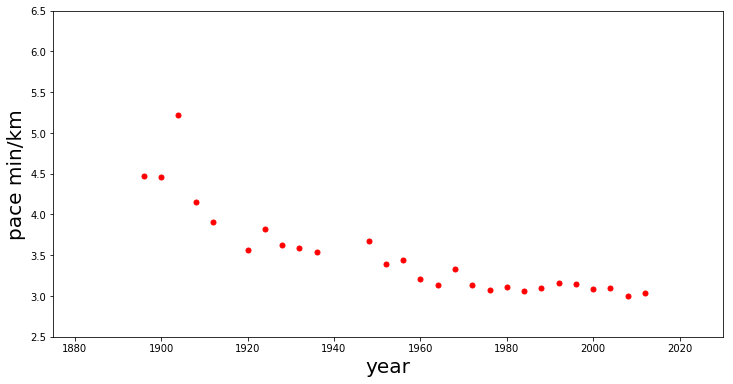

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

offset = y.mean()
scale = np.sqrt(y.var())

xlim = (1875,2030)
ylim = (2.5, 6.5)
yhat = (y-offset)/scale

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/olympic-marathon.svg', transparent=True, frameon=True)


Things to notice about the data include the outlier in 1904, in this year, the olympics was in St Louis, USA. Organizational problems and challenges with dust kicked up by the cars following the race meant that participants got lost, and only very few participants completed. 

More recent years see more consistently quick marathons.

Our first objective will be to perform a Gaussian process fit to the data, we'll do this using the [GPy software](https://github.com/SheffieldML/GPy). 

In [3]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


The first command sets up the model, then 
```
m_full.optimize()
```
optimizes the parameters of the covariance function and the noise level of the model. Once the fit is complete, we'll try creating some test points, and computing the output of the GP model in terms of the mean and standard deviation of the posterior functions between 1870 and 2030. We plot the mean function and the standard deviation at 200 locations. We can obtain the predictions using
```
y_mean, y_var = m_full.predict(xt)
```

In [4]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

Now we plot the results using the helper function ```gpplot```. 

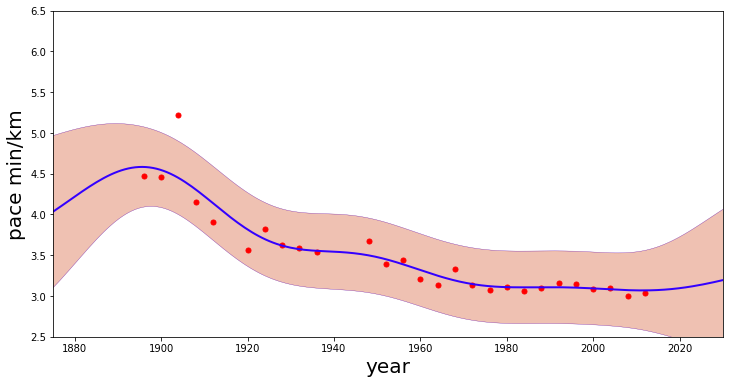

In [5]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
def plot_model_output(model, output_dim=0, scale=1.0, offset=0.0, ax=None, xlabel='$x$', ylabel='$y$', fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.plot(model.X.flatten(), model.Y[:, output_dim]*scale + offset, 'r.',markersize=10)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    xt = plot.pred_range(model.X, portion=portion)
    yt_mean, yt_var = model.predict(xt)
    yt_mean = yt_mean*scale + offset
    yt_var *= scale*scale
    yt_sd=np.sqrt(yt_var)
    if yt_sd.shape[1]>1:
        yt_sd = yt_sd[:, output_dim]

    _ = gpplot(xt.flatten(),
               yt_mean[:, output_dim],
               yt_mean[:, output_dim]-2*yt_sd.flatten(),
               yt_mean[:, output_dim]+2*yt_sd.flatten(), 
               ax=ax)

plot_model_output(m_full, scale=scale, offset=offset, ax=ax, xlabel='year', ylabel='pace min/km', fontsize=20, portion=0.2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig,
                  filename='../../slides/diagrams/gp/olympic-marathon-gp.svg', 
                  transparent=True, frameon=True)

### Fit Quality

In the fit we see that the error bars (coming mainly from the noise variance) are quite large. This is likely due to the outlier point in 1904, ignoring that point we can see that a tighter fit is obtained. To see this making a version of the model, ```m_clean```, where that point is removed. 

```
x_clean=np.vstack((x[0:2, :], x[3:, :]))
y_clean=np.vstack((y[0:2, :], y[3:, :]))

m_clean = GPy.models.GPRegression(x_clean,y_clean)
_ = m_clean.optimize()
```


### Deep GP Fit

Let's see if a deep Gaussian process can help here. We will construct a deep Gaussian process with one hidden layer (i.e. one Gaussian process feeding into another). 

Build a Deep GP with an additional hidden layer (one dimensional) to fit the model.

In [6]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=yhat, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

Deep Gaussian process models also can require some thought in initialization. Here we choose to start by setting the noise variance to be one percent of the data variance.

Optimization requires moving variational parameters in the hidden layer representing the mean and variance of the expected values in that layer. Since all those values can be scaled up, and this only results in a downscaling in the output of the first GP, and a downscaling of the input length scale to the second GP. It makes sense to first of all fix the scales of the covariance function in each of the GPs.

Sometimes, deep Gaussian processes can find a local minima which involves increasing the noise level of one or more of the GPs. This often occurs because it allows a minimum in the KL divergence term in the lower bound on the likelihood. To avoid this minimum we habitually train with the likelihood variance (the noise on the output of the GP) fixed to some lower value for some iterations.

Let's create a helper function to initialize the models we use in the notebook.

In [7]:
def initialize(self, noise_factor=0.01, linear_factor=1):
    """Helper function for deep model initialization."""
    self.obslayer.likelihood.variance = self.Y.var()*noise_factor
    for layer in self.layers:
        if type(layer.X) is GPy.core.parameterization.variational.NormalPosterior:
            if layer.kern.ARD:
                var = layer.X.mean.var(0)
            else:
                var = layer.X.mean.var()
        else:
            if layer.kern.ARD:
                var = layer.X.var(0)
            else:
                var = layer.X.var()

        # Average 0.5 upcrossings in four standard deviations. 
        layer.kern.lengthscale = linear_factor*np.sqrt(layer.kern.input_dim)*2*4*np.sqrt(var)/(2*np.pi)
# Bind the new method to the Deep GP object.
deepgp.DeepGP.initialize=initialize

# Call the initalization
m.initialize()

Now optimize the model. The first stage of optimization is working on variational parameters and lengthscales only. 
```
m.optimize(messages=False,max_iters=100)
```

Now we remove the constraints on the scale of the covariance functions associated with each GP and optimize again.
```
for layer in m.layers:
    pass #layer.kern.variance.constrain_positive(warning=False)
m.obslayer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
```

Finally, we allow the noise variance to change and optimize for a large number of iterations.
```
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)
```

For our optimization process we define a new function.

In [8]:
def staged_optimize(self, iters=(1000,1000,10000), messages=(False, False, True)):
    """Optimize with parameters constrained and then with parameters released"""
    for layer in self.layers:
        # Fix the scale of each of the covariance functions.
        layer.kern.variance.fix(warning=False)
        layer.kern.lengthscale.fix(warning=False)

        # Fix the variance of the noise in each layer.
        layer.likelihood.variance.fix(warning=False)

    self.optimize(messages=messages[0],max_iters=iters[0])
    
    for layer in self.layers:
        layer.kern.lengthscale.constrain_positive(warning=False)
    self.obslayer.kern.variance.constrain_positive(warning=False)


    self.optimize(messages=messages[1],max_iters=iters[1])

    for layer in self.layers:
        layer.kern.variance.constrain_positive(warning=False)
        layer.likelihood.variance.constrain_positive(warning=False)
    self.optimize(messages=messages[2],max_iters=iters[2])
    
# Bind the new method to the Deep GP object.
deepgp.DeepGP.staged_optimize=staged_optimize

In [9]:
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0007   6.687358e+01   3.074403e+02 
    00s18  0008   6.518409e+01   7.608171e+02 
    02s20  0121   3.433225e+01   1.380222e+00 
    07s24  0488   3.417881e+01   3.042155e-01 
    10s25  0777   3.408757e+01   5.644791e-02 
    12s40  1002   3.405815e+01   1.454232e-02 
Runtime:     12s40
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   4.880246e+01   1.226789e+05 
    00s18  0010   2.774690e+01   1.169144e+02 
    02s18  0213   2.309456e+01   1.616419e+00 
    08s21  0809   2.095548e+01   2.278163e+01 
    10s15  1002   2.016496e+01   3.579198e-01 
Runtime:     10s15
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s02  00001   2.016496e+01   4.764877e-

### Plot the prediction

The prediction of the deep GP can be extracted in a similar way to the normal GP. Although, in this case, it is an approximation to the true distribution, because the true distribution is not Gaussian. 

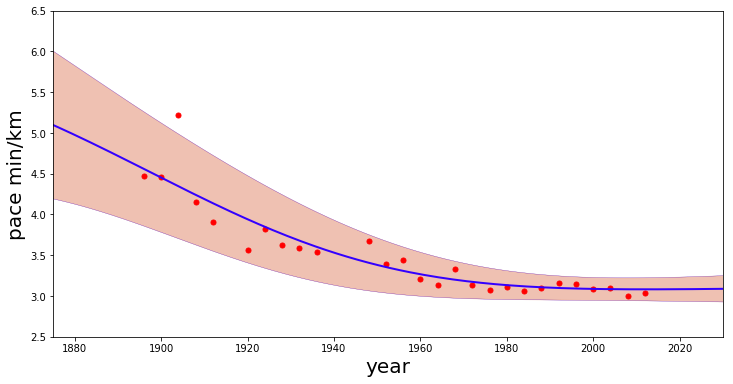

In [10]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, xlabel='year', ylabel='pace min/km', 
          fontsize=20, portion=0.2)
ax.set_xlim(xlim)

ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp.svg', 
                transparent=True, frameon=True)

### Fitted GP for each layer

Now we explore the GPs the model has used to fit each layer. First of all, we look at the hidden layer.

In [11]:
def visualize(self, scale=1.0, offset=0.0, xlabel='input', ylabel='output', 
              xlim=None, ylim=None, fontsize=20, portion=0.2,dataset=None, 
              diagrams='../diagrams'):
    """Visualize the layers in a deep GP with one-d input and output."""
    depth = len(self.layers)
    if dataset is None:
        fname = 'deep-gp-layer'
    else:
        fname = dataset + '-deep-gp-layer'
    filename = os.path.join(diagrams, fname)
    last_name = xlabel
    last_x = self.X
    for i, layer in enumerate(reversed(self.layers)):
        if i>0:
            plt.plot(last_x, layer.X.mean, 'r.',markersize=10)
            last_x=layer.X.mean
            ax=plt.gca()
            name = 'layer ' + str(i)
            plt.xlabel(last_name, fontsize=fontsize)
            plt.ylabel(name, fontsize=fontsize)
            last_name=name
            mlai.write_figure(filename=filename + '-' + str(i-1) + '.svg', 
                              transparent=True, frameon=True)
            
        if i==0 and xlim is not None:
            xt = plot.pred_range(np.array(xlim), portion=0.0)
        elif i>0:
            xt = plot.pred_range(np.array(next_lim), portion=0.0)
        else:
            xt = plot.pred_range(last_x, portion=portion)
        yt_mean, yt_var = layer.predict(xt)
        if layer==self.obslayer:
            yt_mean = yt_mean*scale + offset
            yt_var *= scale*scale
        yt_sd = np.sqrt(yt_var)
        gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
        ax = plt.gca()
        if i>0:
            ax.set_xlim(next_lim)
        elif xlim is not None:
            ax.set_xlim(xlim)
        next_lim = plt.gca().get_ylim()
        
    plt.plot(last_x, self.Y*scale + offset, 'r.',markersize=10)
    plt.xlabel(last_name, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    mlai.write_figure(filename=filename + '-' + str(i) + '.svg', 
                      transparent=True, frameon=True)

    if ylim is not None:
        ax=plt.gca()
        ax.set_ylim(ylim)

# Bind the new method to the Deep GP object.
deepgp.DeepGP.visualize=visualize


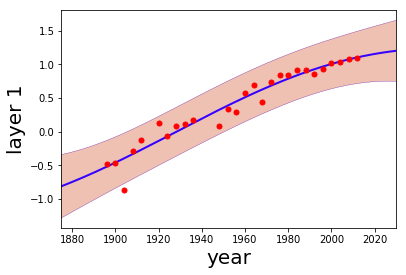

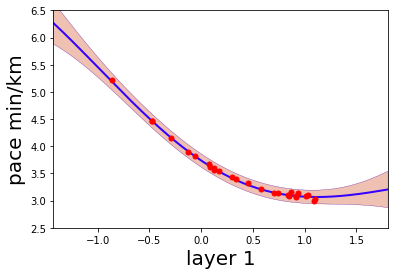

In [12]:
m.visualize(scale=scale, offset=offset, xlabel='year',
            ylabel='pace min/km',xlim=xlim, ylim=ylim,
            dataset='olympic-marathon',
            diagrams='../../slides/diagrams/deepgp')

In [25]:
def visualize_pinball(self, ax=None, scale=1.0, offset=0.0, xlabel='input', ylabel='output', 
                  xlim=None, ylim=None, fontsize=20, portion=0.2, points=50):
    """Visualize the layers in a deep GP with one-d input and output."""
    depth = len(self.layers)
    last_name = xlabel
    last_x = self.X
    #cols = int(np.ceil(depth/2))
    #rows = 2
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    # Recover input and output scales
    plot_model_output(self, scale=scale, offset=offset, ax=ax, 
                      xlabel=xlabel, ylabel=ylabel, 
                      fontsize=fontsize, portion=portion)
    xlim=ax.get_xlim()
    xticks=ax.get_xticks()
    xtick_labels=ax.get_xticklabels().copy()
    ylim=ax.get_ylim()
    yticks=ax.get_yticks()
    ytick_labels=ax.get_yticklabels().copy()
    ax.cla()
    #fig, ax = plt.subplots(nrows=rows, ncols=cols, plot.big_wide_figsize)
    def pinball(x, y, y_std, color_scale=None, layer=0, depth=1, ax=None, alpha=1.0, portion=0.0):        
        if np.dot((x-x.mean()).T, (y-y.mean()))<0:
            y=-y
            flip=-1
        else:
            flip=1
        def scale_data(x, portion):     
            minx = x.min()
            spanx = x.max()-minx
            return (x-minx)/(spanx*(1+portion))
        y_std /= ((y.max()-y.min())*1+portion)
        scalex = scale_data(x, portion=portion)
        scaley = scale_data(y, portion=portion)
        if color_scale is not None:
            color_scale=scale_data(color_scale, portion=0)
        if ax is None:
            fig, ax = plt.subplots(figsize=plot.big_figsize)
        scaley = (1-alpha)*scalex + alpha*scaley
        for i in range(x.shape[0]):
            if color_scale is not None:
                ell=0.1
                weights = np.asarray([np.exp(-0.5*((color_scale[i]-0.125)/ell)**2),
                           np.exp(-0.5*((color_scale[i]-0.5)/ell)**2),
                           np.exp(-0.5*((color_scale[i]-0.875)/ell)**2)]).flatten()
                weights /= weights.sum()
                weights = weights[:, np.newaxis]
                colormat = np.asarray([[1, 0, 0], [1, 1, 0], [0, 1, 0]])
                color = np.dot(colormat.T, weights).flatten()
                #color_scale[i]
                #color=(color_scale[i][0], 1-color_scale[i][0], 0)
            else:
                color=(1, 0, 0)
            x_plot = np.asarray((scalex[i], scaley[i])).flatten()
            y_plot = np.asarray((layer, layer+alpha)).flatten()
            ax.plot(x_plot, y_plot, color=color, alpha=0.5, linewidth=3)
            ax.plot(x_plot, y_plot, color='k', alpha=0.5, linewidth=1)
            
            # Plot error bars that increase as sqrt of distance from start.
            std_points = 50
            stdy = np.linspace(0, alpha,std_points)
            stdx = np.sqrt(stdy)*y_std[i]
            stdy += layer
            mean_vals = np.linspace(scalex[i], scaley[i], std_points)
            upper = mean_vals+stdx 
            lower = mean_vals-stdx 
            fillcolor=color
            ax.fill(np.hstack((upper,lower[::-1])),np.hstack((stdy,stdy[::-1])),
                    color=fillcolor, alpha=0.1)
            
            # Marker to show end point
            ax.plot(scaley[i], layer+alpha, '.',markersize=10, color=color, alpha=0.5)
        ax.set_xlim((0, 1))
        #ax.set_ylim(ax.get_ylim()[::-1])
        ax.invert_yaxis()

        #ax.set_xlim((-1, 1))
        ax.set_ylim((depth, 0))

        ax.set_frame_on(False)
        return flip
    # Whether final axis is flipped
    flip = 1
    for i, layer in enumerate(reversed(self.layers)):     
        if i==0:
            xt = plot.pred_range(last_x, portion=portion, points=points)
            color_scale=xt
        yt_mean, yt_var = layer.predict(xt)
        if layer==self.obslayer:
            yt_mean = yt_mean*scale + offset
            yt_var *= scale*scale
        yt_sd = np.sqrt(yt_var)
        flip = flip*pinball(xt,yt_mean,yt_sd,color_scale,layer=i, ax=ax, depth=depth)#yt_mean-2*yt_sd,yt_mean+2*yt_sd)
        xt = yt_mean
    ax.set_ylim((1.01, -0.1))
    ax.set_yticks(range(depth,0,-1))
    xticks = (yticks-yticks.min())/(yticks.max()-yticks.min())

    ax.set_xticks(xticks)
    ticks = []
    if flip<0:
        tick_list = reversed(yticks)
    else:
        tick_list = yticks
    for tick in reversed(yticks):
        ticks.append(str(tick))
    ax.set_xticklabels(ticks)
    ax.set_xlabel(ylabel)
    ax.text(0.5, -0.05, xlabel, horizontalalignment='center', fontsize=fontsize)
    #for txt in xticklabels:
    #    txt.set
# Bind the new method to the Deep GP object.
deepgp.DeepGP.visualize_pinball=visualize_pinball

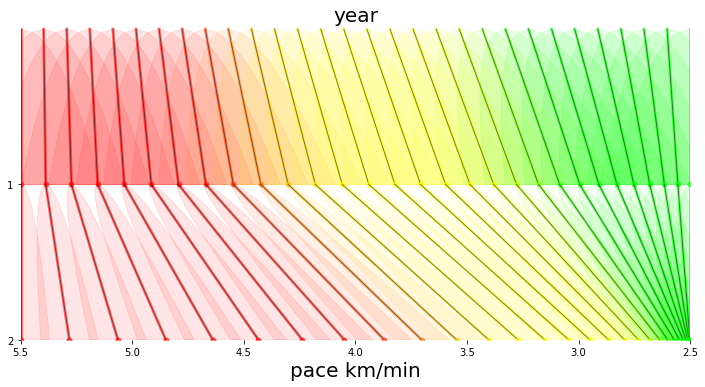

In [26]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
m.visualize_pinball(ax=ax, scale=scale, offset=offset, points=30,portion=0, 
                    xlabel='year', ylabel='pace km/min')
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-pinball.svg', 
                  transparent=True, frameon=True)

In [27]:
def posterior_sample(self, X, **kwargs):
    """Give a sample from the posterior of the deep GP."""
    Z = X
    for i, layer in enumerate(reversed(self.layers)):
        Z = layer.posterior_samples(Z, size=1, **kwargs)[:, :, 0]
 
    return Z
deepgp.DeepGP.posterior_sample = posterior_sample


 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


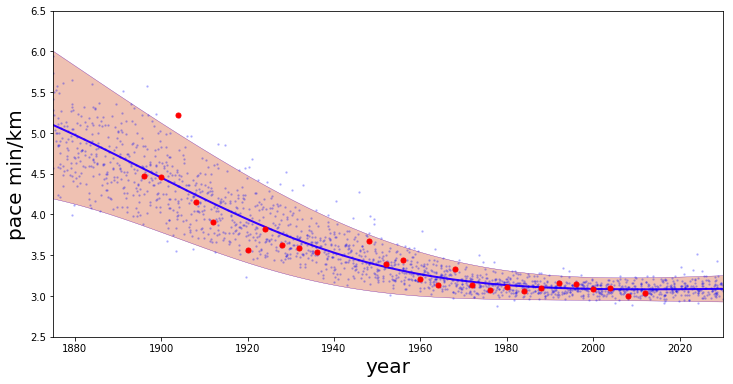

In [28]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
def plot_model_sample(model, output_dim=0, scale=1.0, offset=0.0, samps=10, ax=None, xlabel='$x$', ylabel='$y$', 
                      fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    xt = plot.pred_range(model.X, portion=portion)
    yt_mean, yt_var = model.predict(xt)
    yt_mean = yt_mean*scale + offset
    yt_var *= scale*scale
    yt_sd=np.sqrt(yt_var)
    if yt_sd.shape[1]>1:
        yt_sd = yt_sd[:, output_dim]
        
    _ = gpplot(xt.flatten(),
               yt_mean[:, output_dim],
               yt_mean[:, output_dim]-2*yt_sd.flatten(),
               yt_mean[:, output_dim]+2*yt_sd.flatten(), 
               ax=ax)
    for i in range(samps):
        xt = plot.pred_range(model.X, portion=portion, randomize=True)
        a = model.posterior_sample(xt)
        ax.plot(xt.flatten(), a[:, output_dim]*scale+offset, 'b.',markersize=3, alpha=0.2)
    ax.plot(model.X.flatten(), model.Y[:, output_dim]*scale+offset, 'r.',markersize=10)

plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, 
                  xlabel='year', ylabel='pace min/km', portion = 0.225)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-samples.svg', 
                  transparent=True, frameon=True)


### Motorcycle Crash Data

In [29]:
import pods
data = pods.datasets.mcycle()
x = data['X']
y = data['Y']
scale=np.sqrt(y.var())
offset=y.mean()
yhat = (y - offset)/scale


### Fit a GP Model

In [30]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


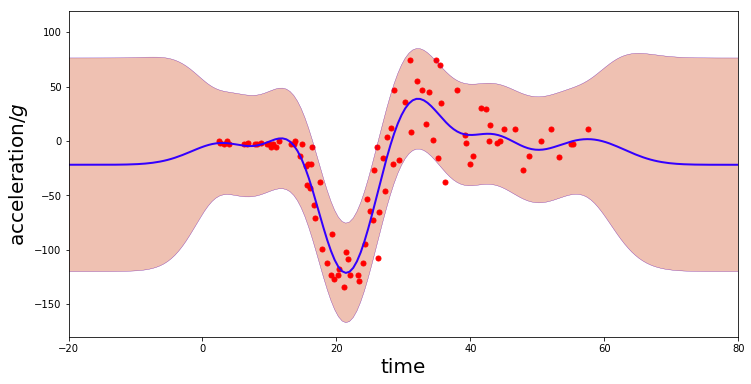

In [31]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, scale=scale, offset=offset, ax=ax, xlabel='time', ylabel='acceleration/$g$', fontsize=20, portion=0.5)
xlim=(-20,80)
ylim=(-180,120)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig,filename='../../slides/diagrams/gp/motorcycle-helmet-gp.svg', 
            transparent=True, frameon=True)

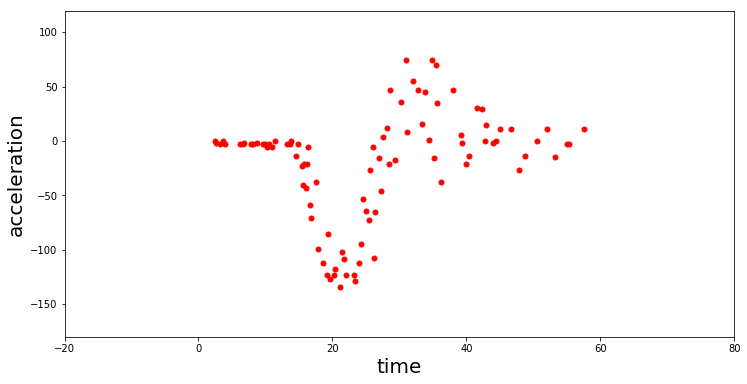

In [32]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('time', fontsize=20)
_ = ax.set_ylabel('acceleration', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(filename='../../slides/diagrams/datasets/motorcycle-helmet.svg', 
            transparent=True, frameon=True)

In [33]:
layers = [y.shape[1], 1, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=yhat, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)



m.initialize()

In [34]:
m.staged_optimize(iters=(1000,1000,10000), messages=(True, True, True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0000   2.301104e+03           nan 
    00s10  0004   7.553973e+02   5.827422e+04 
    00s17  0007   5.446288e+02   1.196385e+04 
    01s17  0114   2.485460e+02   2.345789e+01 
    06s20  0631   2.450322e+02   1.692507e-01 
    07s20  0706   2.450093e+02   4.727586e+00 
    09s20  0938   2.449862e+02   4.838470e-02 
    09s74  1002   2.449827e+02   3.125771e-03 
Runtime:     09s74
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0001   2.449827e+02   3.133991e+04 
    00s12  0006   1.927137e+02   2.079665e+03 
    00s19  0010   1.746876e+02   1.155161e+03 
    02s20  0187   8.983003e+01   1.729946e+02 
    03s20  0293   8.616911e+01   1.287196e+01 
    09s79  1002   8.563504e+01   3.082776e-01 
Runtime:     09s79
Optimization status: Maximum number of f evaluations reache

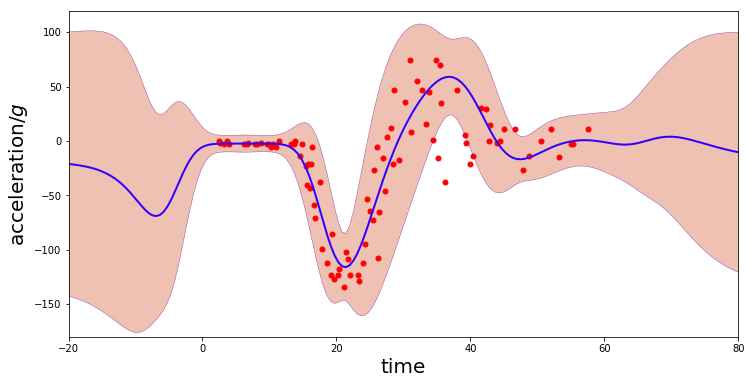

In [35]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, xlabel='time', ylabel='acceleration/$g$', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp.svg', 
            transparent=True, frameon=True)

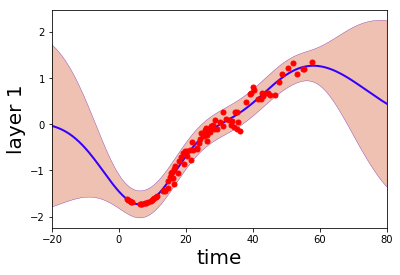

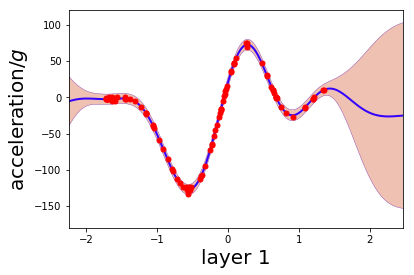

In [36]:
m.visualize(xlim=xlim, ylim=ylim, scale=scale,offset=offset, 
            xlabel="time", ylabel="acceleration/$g$", portion=0.5,
            dataset='motorcycle-helmet',
            diagrams='../../slides/diagrams/deepgp')

 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


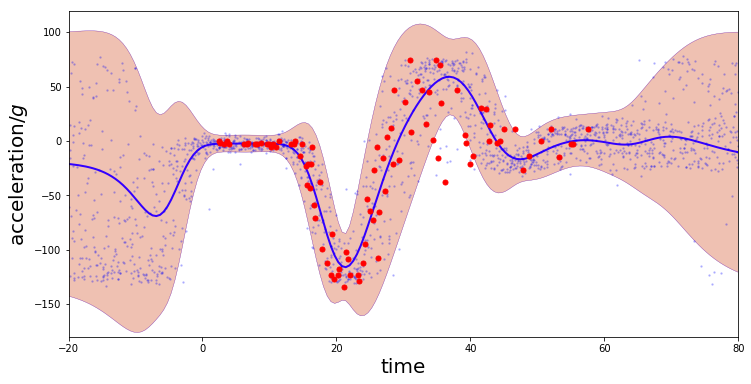

In [37]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, xlabel='time', ylabel='acceleration/$g$', portion = 0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-samples.svg', 
                  transparent=True, frameon=True)

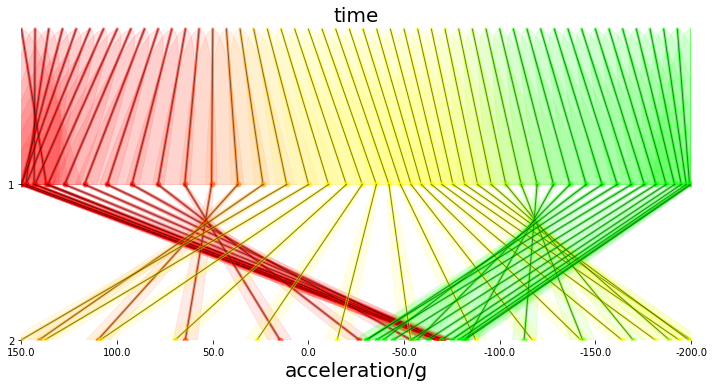

In [39]:
m.visualize_pinball(xlabel='time', ylabel='acceleration/g', 
                    points=50, scale=scale, offset=offset, portion=0.)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp-pinball.svg', 
                  transparent=True, frameon=True)

### Robot Wireless Data

The robot wireless data is taken from an experiment run by Brian Ferris at University of Washington. It consists of the measurements of WiFi access point signal strengths as Brian walked in a loop.

In [ ]:
data=pods.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, np.newaxis]
y = data['Y']
offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale

The ground truth is recorded in the data, the actual loop is given in the plot below.

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
plt.plot(data['X'][:, 1], data['X'][:, 2], 'r.', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/robot-wireless-ground-truth.svg', transparent=True, frameon=True)

We will ignore this ground truth in making our predictions, but see if the model can recover something similar in one of the latent layers.

In [ ]:
output_dim=1
xlim = (-0.3, 1.3)
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x.flatten(), y[:, output_dim], 
            'r.', markersize=5)

ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
xlim = (-0.2, 1.2)
ylim = (-0.6, 2.0)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/robot-wireless-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

Perform a Gaussian process fit on the data using GPy.

In [ ]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function


In [ ]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, output_dim=output_dim, scale=scale, offset=offset, ax=ax, 
                  xlabel='time', ylabel='signal strength', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/gp/robot-wireless-gp-dim-' + str(output_dim)+ '.svg', 
            transparent=True, frameon=True)

In [ ]:
layers = [y.shape[1], 10, 5, 2, 2, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [ ]:
m = deepgp.DeepGP(layers,Y=y, X=x, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.initialize()

In [ ]:
m.staged_optimize(messages=(True,True,True))

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.layers[-2].latent_space.mean[:, 0], 
        m.layers[-2].latent_space.mean[:, 1], 
        'r.-', markersize=5)

ax.set_xlabel('latent dimension 1', fontsize=20)
ax.set_ylabel('latent dimension 2', fontsize=20)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/robot-wireless-latent-space.svg', 
            transparent=True, frameon=True)

In [ ]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, output_dim=output_dim, scale=scale, offset=offset, ax=ax, 
                  xlabel='time', ylabel='signal strength', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/robot-wireless-deep-gp-dim-' + str(output_dim)+ '.svg', 
                  transparent=True, frameon=True)

In [ ]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, output_dim=output_dim, scale=scale, offset=offset, samps=10, ax=ax,
                  xlabel='time', ylabel='signal strength', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/robot-wireless-deep-gp-samples-dim-' + str(output_dim)+ '.svg', 
                  transparent=True, frameon=True)

# Step Function

Finally, we consider a simple step function data set. 

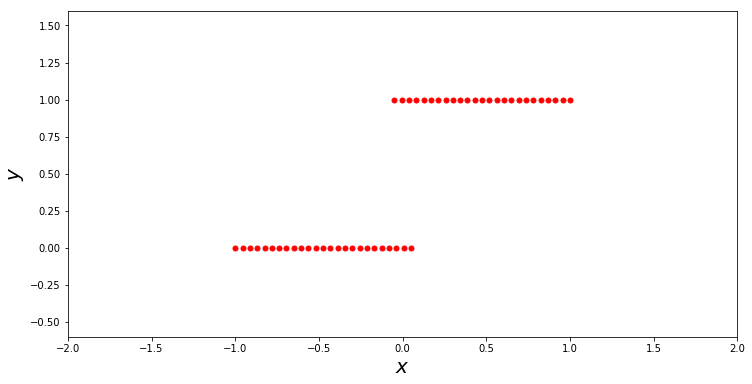

In [40]:
num_low=25
num_high=25
gap = -.1
noise=0.0001
x = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))
scale = np.sqrt(y.var())
offset = y.mean()
yhat = (y-offset)/scale

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('$x$', fontsize=20)
_ = ax.set_ylabel('$y$', fontsize=20)
xlim = (-2, 2)
ylim = (-0.6, 1.6)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/datasets/step-function.svg', 
            transparent=True, frameon=True)

In [41]:
m_full = GPy.models.GPRegression(x,yhat)
_ = m_full.optimize() # Optimize parameters of covariance function

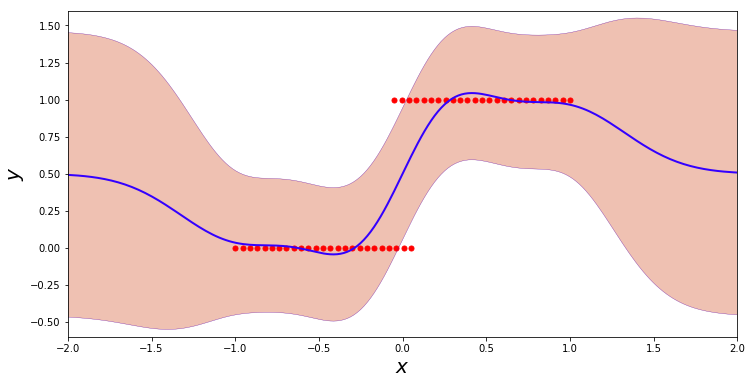

In [42]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m_full, scale=scale, offset=offset, ax=ax, fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

mlai.write_figure(figure=fig,filename='../../slides/diagrams/gp/step-function-gp.svg', 
            transparent=True, frameon=True)

In [43]:
layers = [y.shape[1], 1,x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=yhat, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)

In [44]:
m.initialize()

In [45]:
m.staged_optimize()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s16  00010  -8.952261e+01   3.196865e+03 
    00s19  00012  -1.125422e+02   3.234470e+04 
    02s00  00245  -1.658270e+02   7.179578e-01 
Runtime:     02s00
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



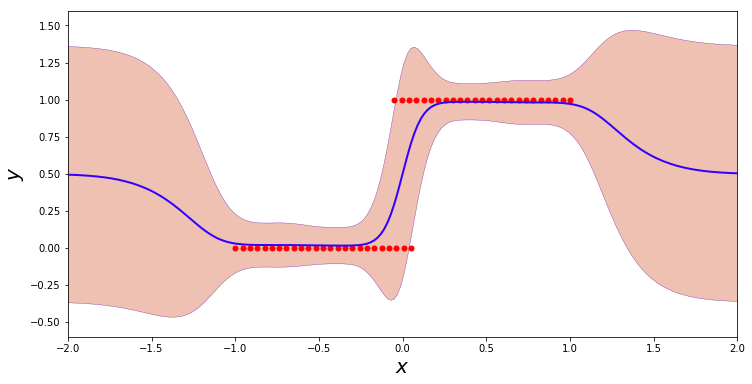

In [46]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_output(m, scale=scale, offset=offset, ax=ax, fontsize=20, portion=0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/step-function-deep-gp.svg', 
            transparent=True, frameon=True)

 /Users/neil/anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:557: RuntimeWarning:covariance is not positive-semidefinite.


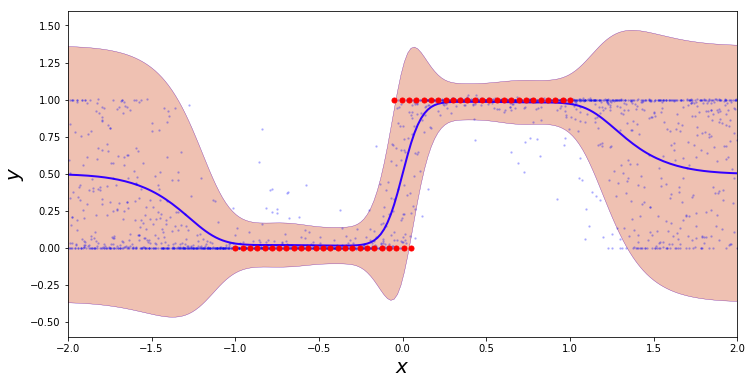

In [47]:
fig, ax=plt.subplots(figsize=plot.big_wide_figsize)
plot_model_sample(m, scale=scale, offset=offset, samps=10, ax=ax, portion = 0.5)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/step-function-deep-gp-samples.svg', 
                  transparent=True, frameon=True)

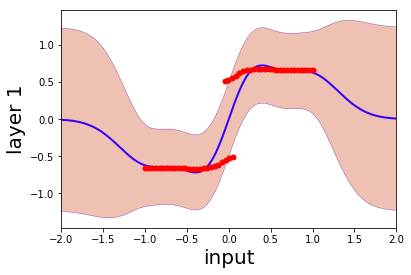

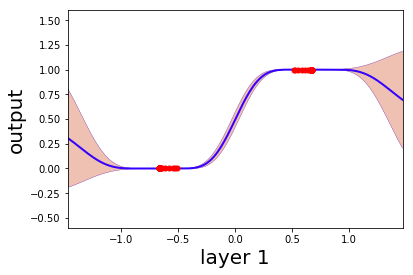

In [48]:
m.visualize(offset=offset, scale=scale, xlim=xlim, ylim=ylim,
            dataset='step-function',
            diagrams='../../slides/diagrams/deepgp')

In [ ]:
m.visualize_pinball(offset=offset, scale=scale, xlim=xlim, ylim=ylim, portion=0.0, points=100)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/step-function-deep-gp-pinball.svg', 
                  transparent=True, frameon=True, ax=ax)

### USPS Digits

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [ ]:
np.random.seed(0)
digits = [0,1,2,3,4]
N_per_digit = 100
Y = []
labels = []
for d in digits:
    imgs = mnist['data'][mnist['target']==d]
    Y.append(imgs[np.random.permutation(imgs.shape[0])][:N_per_digit])
    labels.append(np.ones(N_per_digit)*d)
Y = np.vstack(Y).astype(np.float64)
labels = np.hstack(labels)
Y /= 255.

In [ ]:
num_latent = 2
num_hidden_2 = 5
layers = [Y.shape[1], 15, 12, 10, 8, 6, 2]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]
    

### Initialization

Just like deep neural networks, there are some tricks to intitializing these models. The tricks we use here include some early training of the model with model parameters constrained. This gives the variational inducing parameters some scope to tighten the bound for the case where the noise variance is small and the variances of the Gaussian processes are around 1. 

In [ ]:
m = deepgp.DeepGP(layers,Y=Y, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.initialize(linear_factor=1.0)

In [ ]:
m.layers[0].variational_prior = GPy.core.parameterization.variational.NormalPrior()

In [ ]:
m.layers[0].gradchek()

In [ ]:
m.layers[1].Y.mean - m.layers[0].X.mean

In [ ]:
a = GPy.models.BayesianGPLVM(Y, 15)
a.optimize(messages=True)

In [ ]:
a.X.mean

In [ ]:
a.variational_prior

In [ ]:
m.layers[0].variational_prior

In [ ]:
m.staged_optimize(messages=(True,True,True))

### Visualize the latent space of the top layer

Now the model is trained, let's plot the mean of the posterior distributions in the top latent layer of the model. 

In [ ]:
from matplotlib import rc
rc("font", **{'family':'sans-serif','sans-serif':['Helvetica'],'size':20})
fig, ax = plt.subplots(figsize=plot.big_figsize)
for d in digits:
    ax.plot(m.layers[-1].X.mean[labels==d,0],m.layers[-1].X.mean[labels==d,1],'.',label=str(d))
_ = plt.legend()
mlai.write_figure(figure=fig, filename="../../slides/diagrams/deepgp/usps-digits-latent.svg", transparent=True)

### Visualize the latent space of the intermediate layer

We can also visualize dimensions of the intermediate layer. First the lengthscale of those dimensions is given by

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
for i in range(5):
    for j in range(i):
        dims=[i, j]
        ax.cla()
        for d in digits:
            ax.plot(m.obslayer.X.mean[labels==d,dims[0]],
                 m.obslayer.X.mean[labels==d,dims[1]],
                 '.', label=str(d))
        plt.legend()
        plt.xlabel('dimension ' + str(dims[0]))
        plt.ylabel('dimension ' + str(dims[1]))
        mlai.write_figure(figure=fig, filename="../../slides/diagrams/deepgp/usps-digits-hidden-" + str(dims[0]) + '-' + str(dims[1]) + '.svg', transparent=True)

### Generate From Model

Now we can take a look at a sample from the model, by drawing a Gaussian random sample in the latent space and propagating it through the model. 

In [ ]:
rows = 10
cols = 20
t=np.linspace(-1, 1, rows*cols)[:, None]
kern = GPy.kern.RBF(1,lengthscale=0.05)
cov = kern.K(t, t)
x = np.random.multivariate_normal(np.zeros(rows*cols), cov, num_latent).T

In [ ]:
#x = np.random.randn(rows*cols,num_input)*0.5
yt = m.predict(x)
fig, axs = plt.subplots(rows,cols,figsize=(10,6))
for i in range(rows):
    for j in range(cols):
        #v = np.random.normal(loc=yt[0][i*cols+j, :], scale=np.sqrt(yt[1][i*cols+j, :]))
        v = yt[0][i*cols+j, :]
        axs[i,j].imshow(v.reshape(28,28), 
                        cmap='gray', interpolation='none',
                        aspect='equal')
        axs[i,j].set_axis_off()
mlai.write_figure(figure=fig, filename="../../slides/diagrams/deepgp/digit-samples-deep-gp.svg", transparent=True)

In [ ]:
for layer in m.layers:
    display(layer.kern.lengthscale)

In [ ]:
data=pods.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, np.newaxis]
y = data['Y']
offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale
y_mrd=[]
for i in range(yhat.shape[1]):
    y_mrd.append(yhat[:, i])

In [ ]:
layers = [[1]*yhat.shape[1], 10, 5, 2, 2, x.shape[1]]
inits = ['random'] + ['PCA']*(len(layers)-2)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [ ]:
m = deepgp.DeepGP(layers,Y=y_mrd, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)

In [ ]:
%debug